# Spam Email Classification Using GRU

## Data Loading

In [1]:
# Setup for kaggle API

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
# Downloading dataset via Kaggle

!kaggle datasets download -d purusinghvi/email-spam-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset
License(s): MIT
 95% 41.0M/43.0M [00:00<00:00, 121MB/s]
100% 43.0M/43.0M [00:00<00:00, 107MB/s]


In [3]:
# Extracting data from ZipFile

import zipfile
zipfile_ref = zipfile.ZipFile('/content/email-spam-classification-dataset.zip','r')
zipfile_ref.extractall('/content')
zipfile_ref.close()

## Exploratory Data Analysis

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/combined_data.csv')

In [6]:
df.head(5)

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [7]:
df.shape

(83448, 2)

In [8]:
df.size

166896

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [10]:
df.describe()

,label
count,83448.000000
mean,0.526196
std,0.499316
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [11]:
df.isnull().sum()

,0
label,0
text,0


In [12]:
df.isna().sum()

,0
label,0
text,0


In [13]:
df.duplicated().sum()

0

## Data Visualization

In [21]:
# Creating a duplicate dataframe for data visualization

df_dv = df.copy()

In [22]:
# Labelling Spam or Ham

df_dv.rename(columns={'text': 'Text', 'label': 'Label'}, inplace=True)
df_dv['Label'] = df_dv['Label'].replace({
    0: 'Ham',
    1: 'Spam',
})

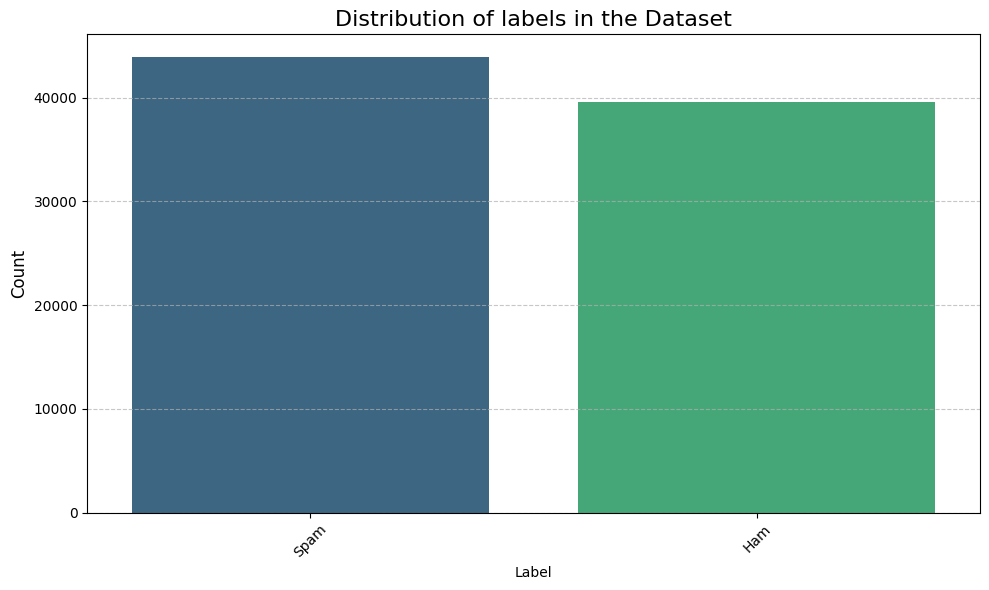

In [23]:
# Visualizing Distribution of Labels

label_counts = df_dv['Label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of labels in the Dataset', fontsize=16)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

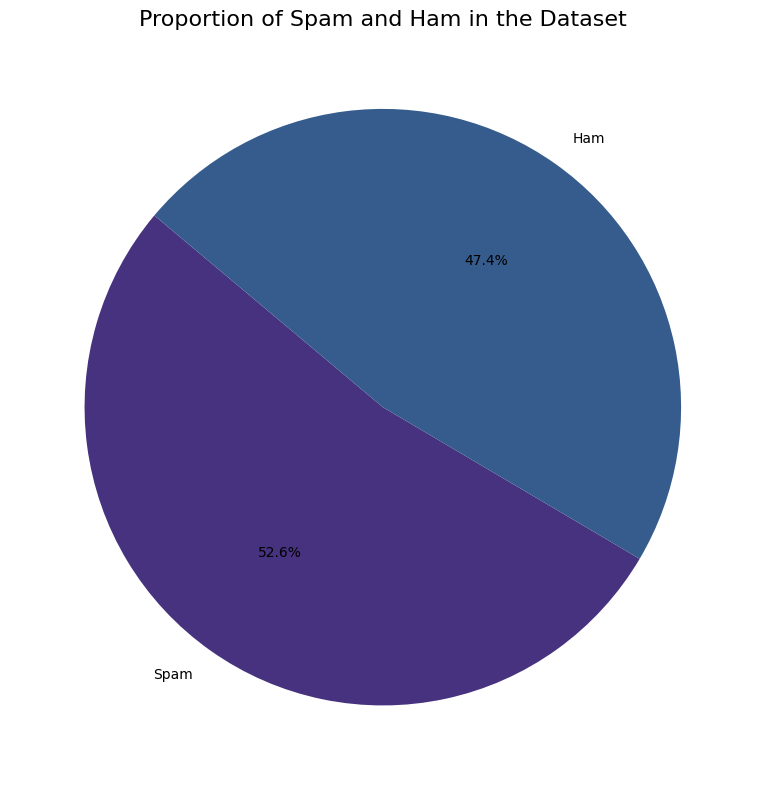

In [24]:
# Visualizing Label Distribution

plt.figure(figsize=(8, 8))

df_dv['Label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
plt.title('Proportion of Spam and Ham in the Dataset', fontsize=16)
plt.ylabel('')
plt.tight_layout()
plt.show()

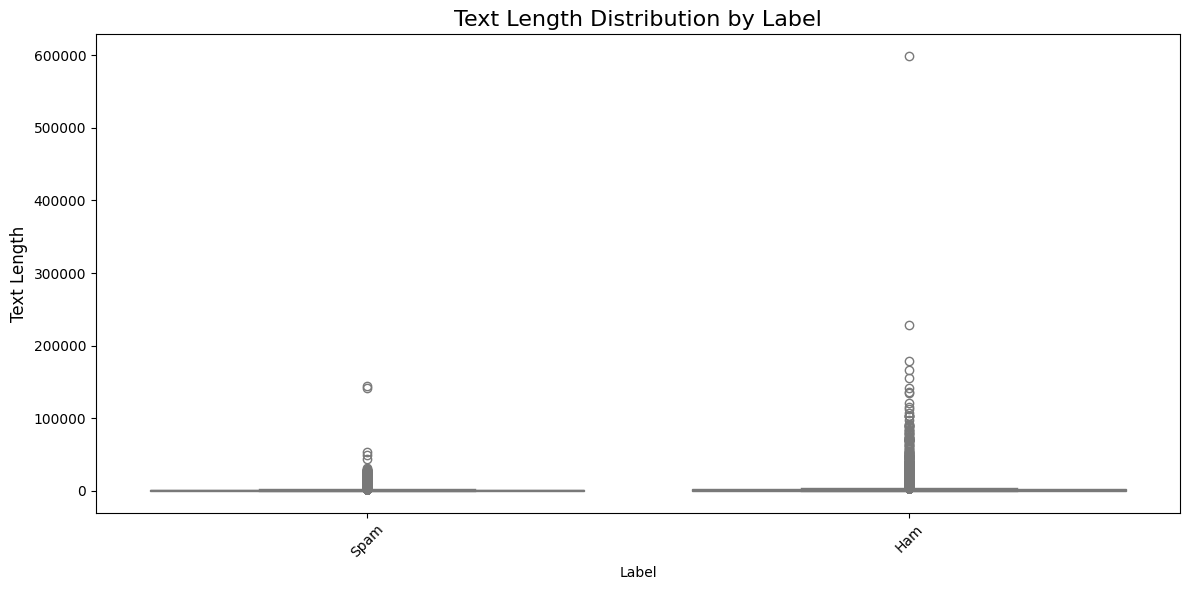

In [27]:
# Representing Text Length Distribution by Labels

df_dv['Text_Length'] = df_dv['Text'].apply(len)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='Text_Length', data=df_dv, palette='coolwarm')
plt.title('Text Length Distribution by Label', fontsize=16)
plt.ylabel('Text Length', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

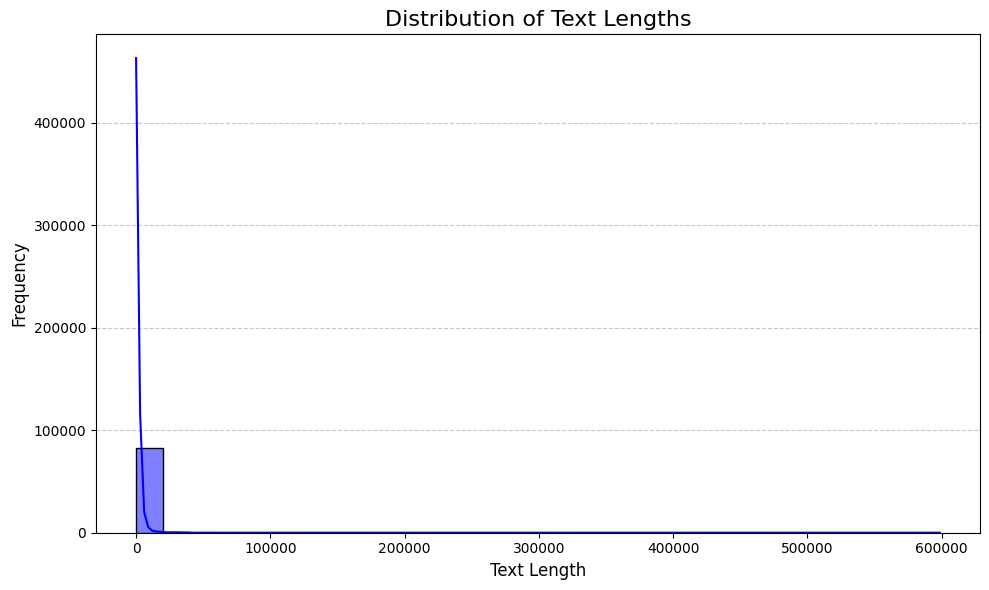

In [29]:
# Plotting Histogram for Distributon of Text Lengths

plt.figure(figsize=(10, 6))
df_dv['Text_Length'] = df_dv['Text'].apply(len)
sns.histplot(df_dv['Text_Length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Text Lengths', fontsize=16)
plt.xlabel('Text Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

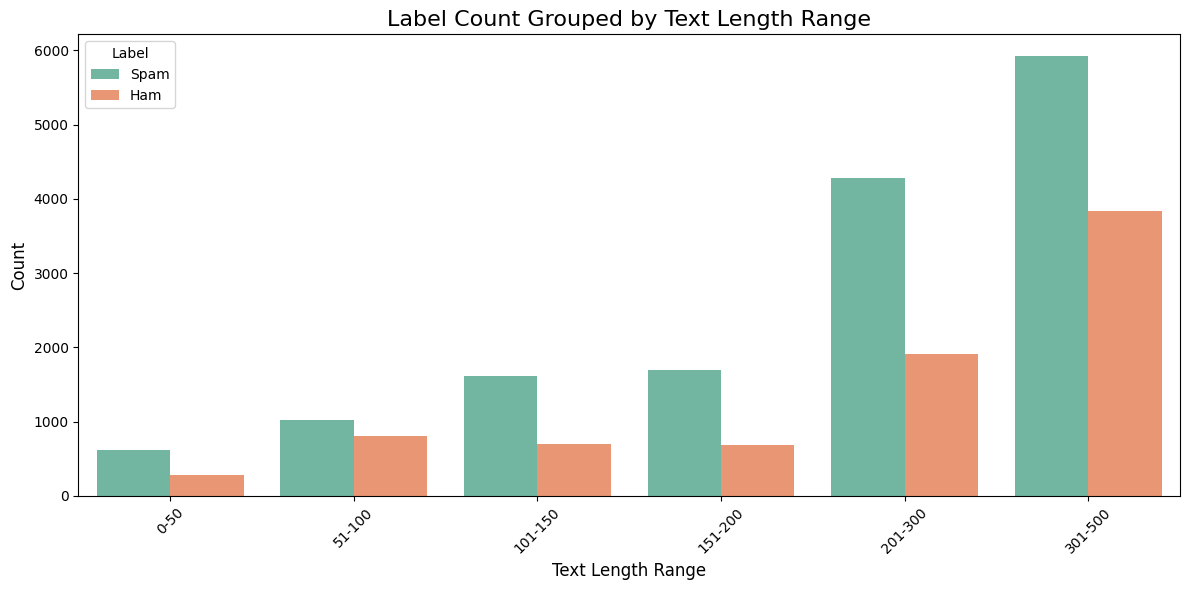

In [31]:
# Visualizing Label Count Grouped by Text Length Range

df_dv['Length_Bin'] = pd.cut(df_dv['Text_Length'], bins=[0, 50, 100, 150, 200, 300, 500],
                          labels=['0-50', '51-100', '101-150', '151-200', '201-300', '301-500'])

plt.figure(figsize=(12, 6))
sns.countplot(x='Length_Bin', hue='Label', data=df_dv, palette='Set2')
plt.title('Label Count Grouped by Text Length Range', fontsize=16)
plt.xlabel('Text Length Range', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

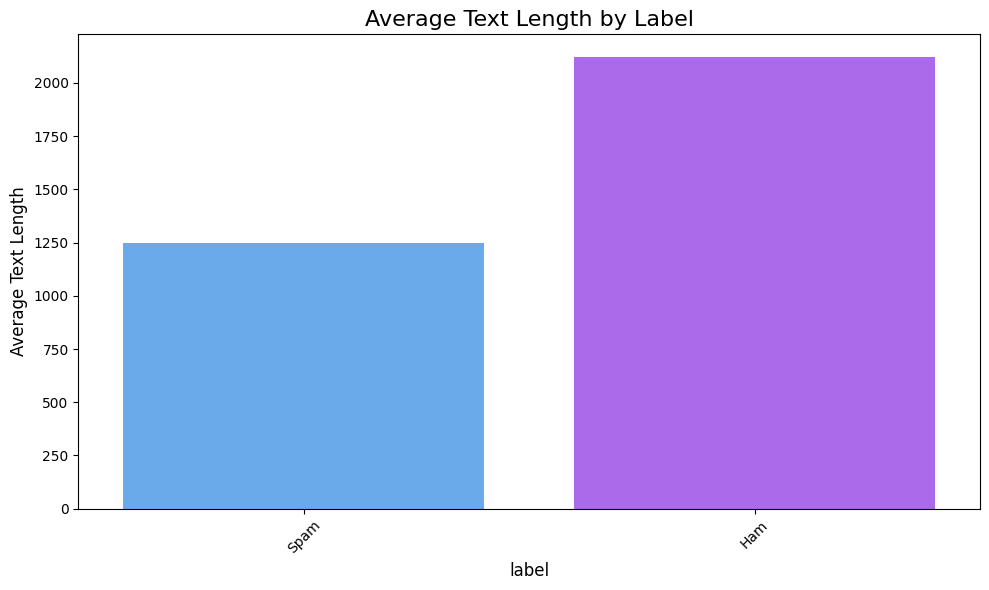

In [33]:
# Visualizing Average Text Length by label

avg_text_length = df_dv.groupby('Label')['Text_Length'].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_text_length.index, y=avg_text_length.values, palette='cool')
plt.title('Average Text Length by Label', fontsize=16)
plt.xlabel('label', fontsize=12)
plt.ylabel('Average Text Length', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

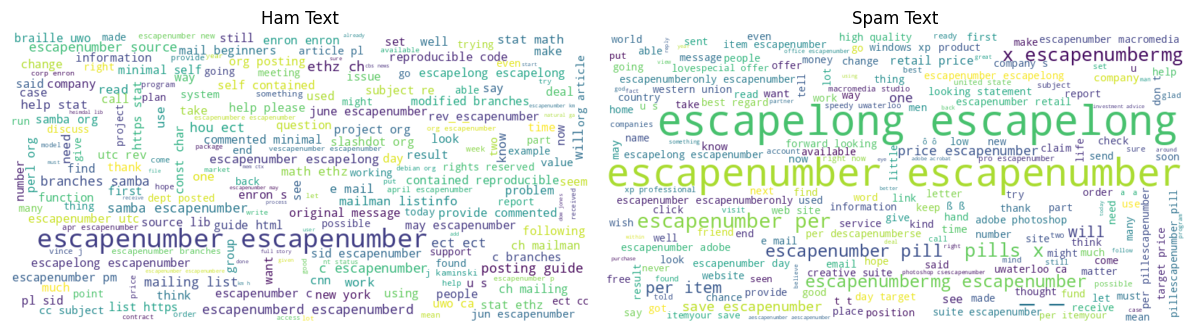

In [34]:
# Creating WordCloud for all the lables

from wordcloud import WordCloud

emotion_dfs = {
    'Ham': df_dv[df_dv['Label'] == 'Ham'],
    'Spam': df_dv[df_dv['Label'] == 'Spam'],
}

plt.figure(figsize=(18, 9))
for i, (emotion, subset) in enumerate(emotion_dfs.items(), 1):
    combined_text = ' '.join(subset['Text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    plt.subplot(2, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{emotion} Text')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Cleaning & Preprocessing

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Creating a pipeline for Data Cleaning

def clean_text_pipeline(df, text_column='Text'):
    stop = set(stopwords.words('english'))

    def clean_text(text):
        text = re.sub(r'http\S+|www\S+|@\S+', '', text)  # Removing URLs and email addresses
        text = re.sub(r'[^\w\s]', '', text)        # Removing special characters and punctuation
        text = re.sub(r'\s+', ' ', text)           # Removing extra whitespaces
        text = text.lower()                        # Lowercasing text

        df[text_column] = df[text_column].apply(clean_text)
    return df

In [6]:
# Data Cleaning

df = clean_text_pipeline(df, text_column='Text')

In [7]:
# Train Test And Split

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Tokenization and Padding

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

maxlen = max(len(tokens) for tokens in X_train_sequences)

X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post',)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

## Model Training

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

In [ ]:
model = Sequential()
model.add(Embedding(8000, 100, input_length=100))
model.add(GRU(128))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=32
)

## Model Prediction

In [ ]:
history_df=pd.DataFrame(history.history)
history_df

In [ ]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')